<a href="https://colab.research.google.com/github/roni762583/ReinforcementLearning/blob/main/RL3mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from: https://github.com/Rachnog/Reinforcement-Learning-in-Finance/blob/main/odsc_workshop/ODSC_RL_2.ipynb

In [ ]:
!ls

sample_data


In [ ]:
!pip install stable-baselines3[extra]
# !pip install yfinance
#from google.colab import drive
#drive.mount('/tick_data/')
#!ls

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
# import yfinance as yf

import gym
from gym import spaces

In [ ]:
# make sure pandas doesn’t hide any columns
pd.set_option("display.max.columns", None)

In [ ]:
# Data loading

INIT_NET_WORTH = 10000
WINDOW = 10
ROLLING = int(252 / 2)

In [ ]:
TICKER = 'myData' # 'COSINE'

if TICKER == 'COSINE':
    df = pd.DataFrame({
        'High': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.01, size = (2000, )),
        'Open': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.01, size = (2000, )),
        'Close': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.01, size = (2000, )),
        'Low': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.01, size = (2000, )),
        'Volume': np.abs(np.sin(np.arange(2000)/100.0)),
      }
      )
else:
    # df = yf.download(TICKER, start="2000-01-01", end="2011-01-01")
    # Load Data
    from google.colab import files
    uploaded = files.upload() 
    filename = list(uploaded.keys())[0]
    colnames=['TIME', 'bid', 'ask', 'tradable'] 
    df = pd.read_csv(filename, names=colnames, header=None)
    print(df.head())
    print(df.dtypes)
    df['datetime'] = pd.to_datetime( df['TIME'], format='%Y%m%d %H%M%S%f' )
    df.head()
    # setting datetime as index column
    df.set_index(df['datetime'], inplace = True)
    # df.head
    # drop extra columns
    df.drop(['datetime','TIME','tradable'], axis=1, inplace=True)
    print("Shape: ",df.shape)
    print(df.head())
    print("count: ",df.count())
# run once

Saving DAT_ASCII_GBPUSD_T_201708.csv to DAT_ASCII_GBPUSD_T_201708.csv
                 TIME      bid      ask  tradable
0  20170801 000001237  1.32142  1.32151         0
1  20170801 000001487  1.32144  1.32153         0
2  20170801 000001737  1.32145  1.32153         0
3  20170801 000001987  1.32144  1.32153         0
4  20170801 000002737  1.32145  1.32153         0
TIME         object
bid         float64
ask         float64
tradable      int64
dtype: object
Shape:  (1083248, 2)
                             bid      ask
datetime                                 
2017-08-01 00:00:01.237  1.32142  1.32151
2017-08-01 00:00:01.487  1.32144  1.32153
2017-08-01 00:00:01.737  1.32145  1.32153
2017-08-01 00:00:01.987  1.32144  1.32153
2017-08-01 00:00:02.737  1.32145  1.32153
count:  bid    1083248
ask    1083248
dtype: int64


In [ ]:
# run only if running second or more times
colnames=['TIME', 'bid', 'ask', 'tradable'] 
df = pd.read_csv(filename, names=colnames, header=None)
print(df.head())
print(df.dtypes)
df['datetime'] = pd.to_datetime( df['TIME'], format='%Y%m%d %H%M%S%f' )
df.head()
# setting datetime as index column
df.set_index(df['datetime'], inplace = True)
# df.head
# drop extra columns
df.drop(['datetime','TIME','tradable'], axis=1, inplace=True)
print("Shape: ",df.shape)
print(df.head())
print("count: ",df.count())

                 TIME      bid      ask  tradable
0  20170801 000001237  1.32142  1.32151         0
1  20170801 000001487  1.32144  1.32153         0
2  20170801 000001737  1.32145  1.32153         0
3  20170801 000001987  1.32144  1.32153         0
4  20170801 000002737  1.32145  1.32153         0
TIME         object
bid         float64
ask         float64
tradable      int64
dtype: object
Shape:  (1083248, 2)
                             bid      ask
datetime                                 
2017-08-01 00:00:01.237  1.32142  1.32151
2017-08-01 00:00:01.487  1.32144  1.32153
2017-08-01 00:00:01.737  1.32145  1.32153
2017-08-01 00:00:01.987  1.32144  1.32153
2017-08-01 00:00:02.737  1.32145  1.32153
count:  bid    1083248
ask    1083248
dtype: int64


In [ ]:
# build Hull Moving Avg. as features of environment
def WMA(s, period):
       return s.rolling(period).apply(lambda x: ((np.arange(period)+1)*x).sum()/(np.arange(period)+1).sum(), raw=True)

def HMA(s, period):
       return WMA(WMA(s, period//2).multiply(2).sub(WMA(s, period)), int(np.sqrt(period)))

In [ ]:
#df["hma5"] = HMA(df.bid, 5) # took >32 sec. to run on 1.08MM rows
#df['deltahma5'] = df.hma5.diff()
#df['deltahma5_5'] = df.hma5.diff(5)
#df['hma5hma5'] = HMA(df.hma5, 5)
#df['deltahma5hma5'] = df.hma5hma5.diff()
#df['deltahma5hma5_5'] = df.hma5hma5.diff(5) # divide by n+1 ticks to get avg. 
#df["hma20"] = HMA(df.bid, 20)
#df['bidhma20diff'] = df.bid - df.hma20
#df['bidhma50diff'] = df.bid - df.hma50

df['spread'] = df.ask - df.bid
# ma's
df['hma50'] = HMA(df.bid, 50)
df['hma200'] = HMA(df.bid, 200)
df['hma1000'] = HMA(df.bid, 1000)
df['hma5000'] = HMA(df.bid, 5000) # took 50 sec. to run this line

# log returns lr_
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

df['lr_hma50'] = log_return(HMA(df.bid, 50))
df['lr_hma200'] = log_return(HMA(df.bid, 200))
df['lr_hma1000'] = log_return(HMA(df.bid, 1000))
df['lr_hma5000'] = log_return(HMA(df.bid, 5000))
# ma momentums
df['mom10_hma50'] = df.hma50.diff(10)
df['mom10_hma200'] = df.hma200.diff(10)
df['mom10_hma1000'] = df.hma1000.diff(10)
df['mom10_hma5000'] = df.hma5000.diff(10)

# distance beteween ma's - take small period avg. minus large period
df['delta_hma50_hma5000'] = df.hma50 - df.hma5000
df['delta_hma50_hma200'] = df.hma50 - df.hma200
df['delta_hma200_hma1000'] = df.hma200 - df.hma1000
df['delta_hma1000_hma5000'] = df.hma1000 - df.hma5000
df['delta_hma200_hma5000'] = df.hma200 - df.hma5000

In [ ]:
# get rid o NA rows
print('before removing Nans',df.count())
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)


# add Open High Low Close columns to df to work with example code expectation
df['Open'] = df.bid
df['High'] = df.bid
df['Low'] = df.bid
df['Close'] = df.bid
df['Volume'] = 1
df.index.name = "Date"

print('after removing Nans, and adding Open High Low Close columns',df.count())

before removing Nans bid                      1078170
ask                      1078170
spread                   1078170
hma50                    1078170
hma200                   1078170
hma1000                  1078170
hma5000                  1078170
lr_hma50                 1078170
lr_hma200                1078170
lr_hma1000               1078170
lr_hma5000               1078170
mom10_hma50              1078170
mom10_hma200             1078170
mom10_hma1000            1078170
mom10_hma5000            1078170
delta_hma50_hma5000      1078170
delta_hma50_hma200       1078170
delta_hma200_hma1000     1078170
delta_hma1000_hma5000    1078170
delta_hma200_hma5000     1078170
Open                     1078170
High                     1078170
Low                      1078170
Close                    1078170
dtype: int64
after removing Nans, and adding Open High Low Close columns bid                      1078170
ask                      1078170
spread                   1078170
hma50          

In [ ]:
'''
# Ratio of MA differences to largest difference (between the two extreme ma periods)


# eliminate zero denominator
def GetNonZeroDen(s, epsilon): 
        # s-series, epsilon-min. magnitude of denominator ex. 0.000001
        return s.apply(lambda x: ( x if abs(x)>epsilon else np.nan))

epsilon = 0.0001 # minimal denominator value

df['ratio_50delta200_tofullrange']    = abs(df.delta_hma50_hma200)    / abs(GetNonZeroDen(df.delta_hma50_hma5000, epsilon))
df['ratio_200delta1000_tofullrange']  = abs(df.delta_hma200_hma1000)  / abs(GetNonZeroDen(df.delta_hma50_hma5000, epsilon))
df['ratio_1000delta5000_tofullrange'] = abs(df.delta_hma1000_hma5000) / abs(GetNonZeroDen(df.delta_hma50_hma5000, epsilon))

print(df.ratio_50delta200_tofullrange.isna().sum())
# replace NaN's with previous value of ratios to keep time series continous
df.ratio_50delta200_tofullrange.fillna(method='ffill', inplace=True)
df.ratio_200delta1000_tofullrange.fillna(method='ffill', inplace=True)
df.ratio_1000delta5000_tofullrange.fillna(method='ffill', inplace=True)

print(df.ratio_50delta200_tofullrange.isna().sum())
'''

"\n# Ratio of MA differences to largest difference (between the two extreme ma periods)\n\n\n# eliminate zero denominator\ndef GetNonZeroDen(s, epsilon): \n        # s-series, epsilon-min. magnitude of denominator ex. 0.000001\n        return s.apply(lambda x: ( x if abs(x)>epsilon else np.nan))\n\nepsilon = 0.0001 # minimal denominator value\n\ndf['ratio_50delta200_tofullrange']    = abs(df.delta_hma50_hma200)    / abs(GetNonZeroDen(df.delta_hma50_hma5000, epsilon))\ndf['ratio_200delta1000_tofullrange']  = abs(df.delta_hma200_hma1000)  / abs(GetNonZeroDen(df.delta_hma50_hma5000, epsilon))\ndf['ratio_1000delta5000_tofullrange'] = abs(df.delta_hma1000_hma5000) / abs(GetNonZeroDen(df.delta_hma50_hma5000, epsilon))\n\nprint(df.ratio_50delta200_tofullrange.isna().sum())\n# replace NaN's with previous value of ratios to keep time series continous\ndf.ratio_50delta200_tofullrange.fillna(method='ffill', inplace=True)\ndf.ratio_200delta1000_tofullrange.fillna(method='ffill', inplace=True)\ndf.

'\n# Ratio of MA differences to largest difference (between the two extreme ma periods)\naxs[15].plot(df.ratio_50delta200_tofullrange.iloc[rowsList])\naxs[15].set_title("ratio_50delta200_tofullrange")\n\naxs[16].plot(df.ratio_200delta1000_tofullrange.iloc[rowsList])\naxs[16].set_title("ratio_200delta1000_tofullrange")\n\naxs[17].plot(df.ratio_1000delta5000_tofullrange.iloc[rowsList])\naxs[17].set_title("ratio_1000delta5000_tofullrange")\n'

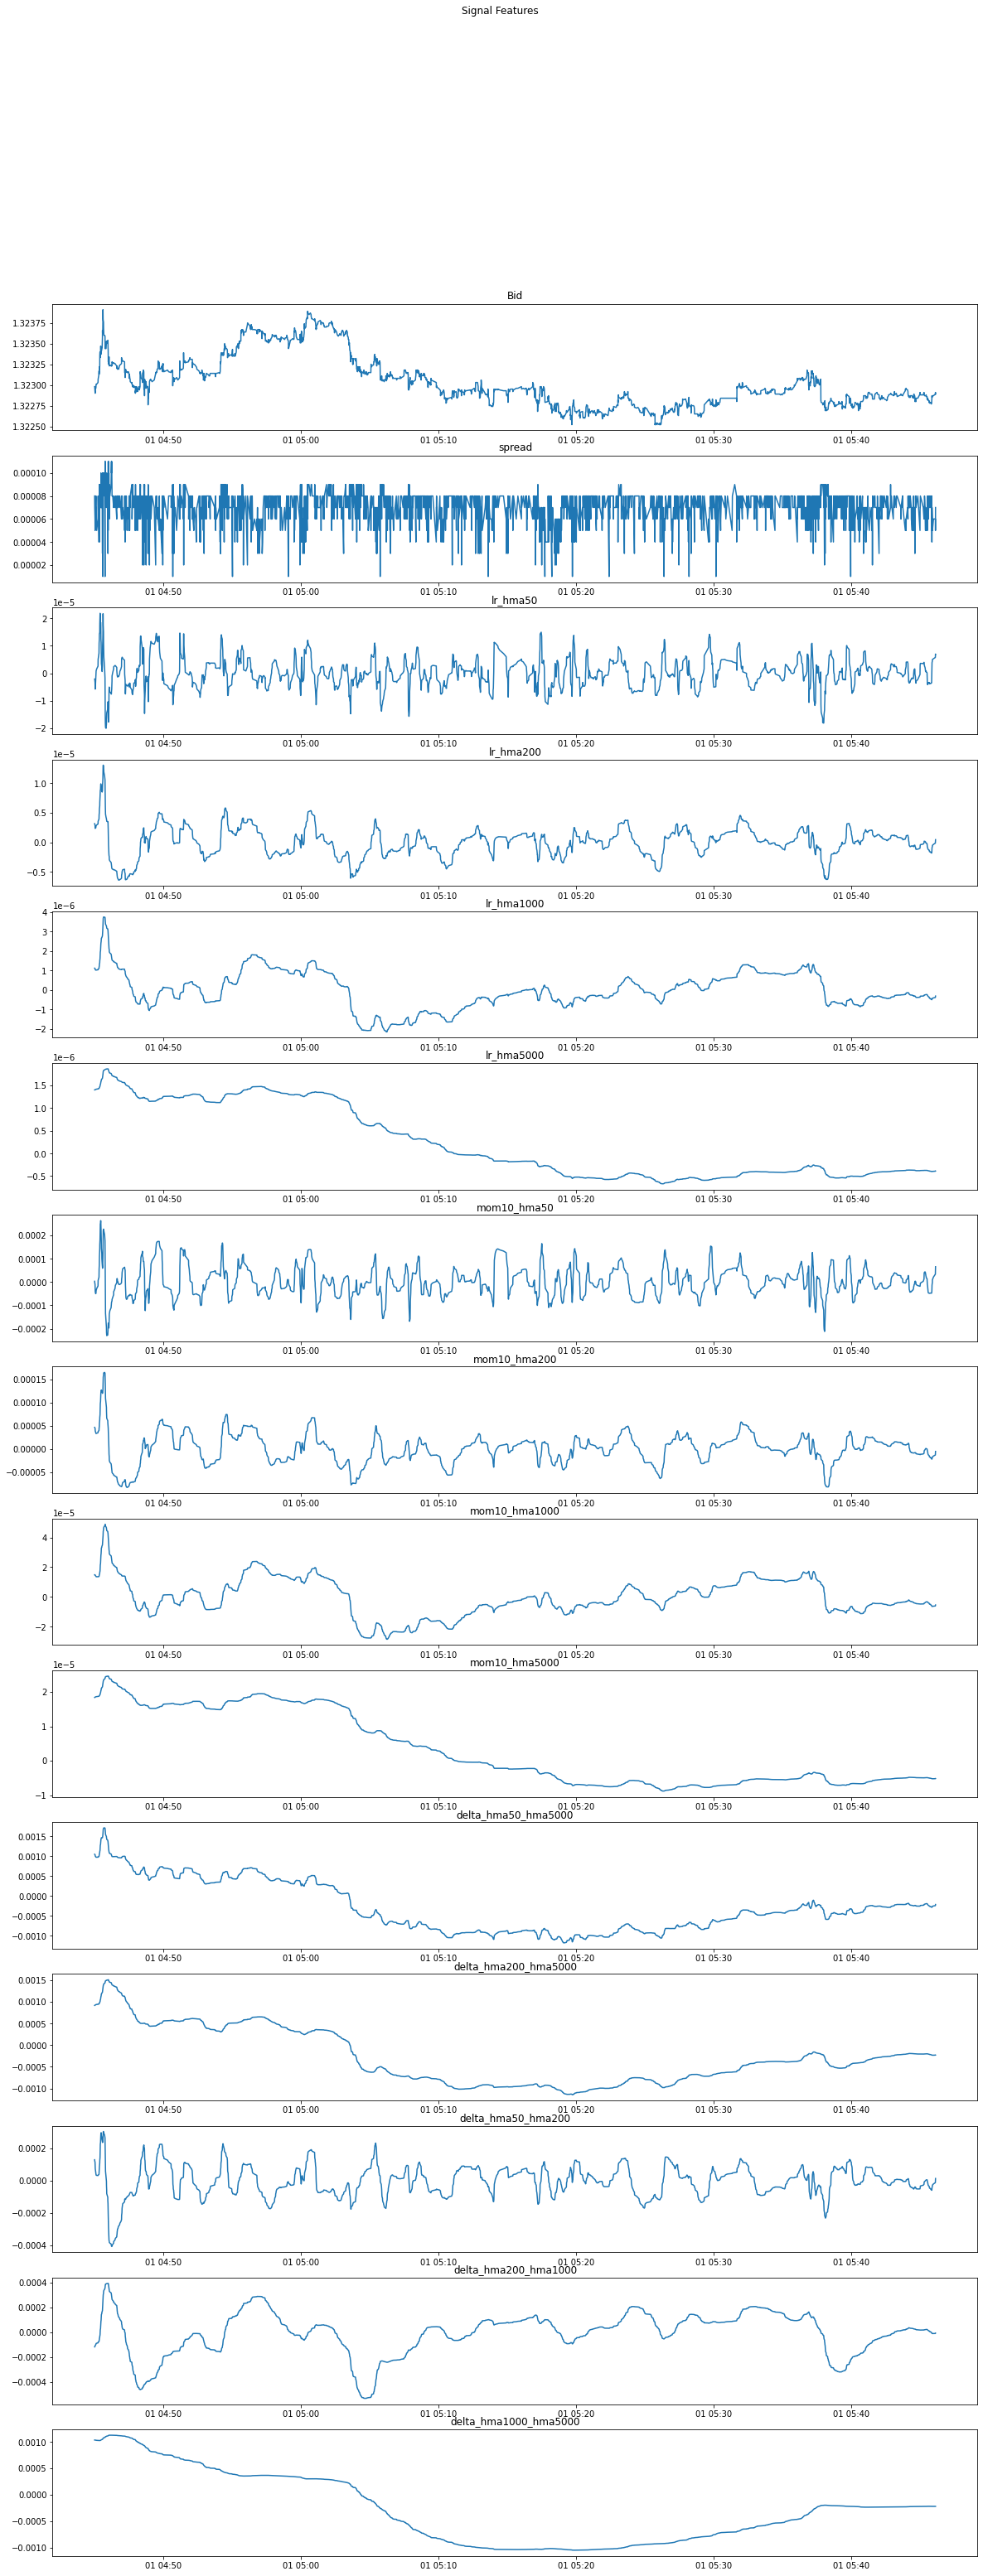

In [ ]:
# plot 

rowsList = list(range(4000,6800))

fig, axs = plt.subplots(15, figsize=(20,50))
fig.suptitle('Signal Features')


axs[0].plot(df.bid.iloc[rowsList])
axs[0].set_title("Bid")
 
axs[1].plot(df.spread.iloc[rowsList])
axs[1].set_title("spread")

# log returns of ma's
axs[2].plot(df.lr_hma50.iloc[rowsList]) # this filters sufficiently, yet retains bid line shape with enough detail
axs[2].set_title("lr_hma50")
 
axs[3].plot(df.lr_hma200.iloc[rowsList])
axs[3].set_title("lr_hma200")
 
axs[4].plot(df.lr_hma1000.iloc[rowsList])
axs[4].set_title("lr_hma1000")
 
axs[5].plot(df.lr_hma5000.iloc[rowsList])
axs[5].set_title("lr_hma5000")

# MA momentums
axs[6].plot(df.mom10_hma50.iloc[rowsList])
axs[6].set_title("mom10_hma50")

axs[7].plot(df.mom10_hma200.iloc[rowsList])
axs[7].set_title("mom10_hma200")

axs[8].plot(df.mom10_hma1000.iloc[rowsList])
axs[8].set_title("mom10_hma1000")

axs[9].plot(df.mom10_hma5000.iloc[rowsList])
axs[9].set_title("mom10_hma5000")

# distance beteween ma's - take small period avg. minus large period => (+) is leading upwards
axs[10].plot(df.delta_hma50_hma5000.iloc[rowsList]) 
axs[10].set_title("delta_hma50_hma5000")

axs[11].plot(df.delta_hma200_hma5000.iloc[rowsList]) 
axs[11].set_title("delta_hma200_hma5000")


# adjacent ma's (neigbors by period)
axs[12].plot(df.delta_hma50_hma200.iloc[rowsList])
axs[12].set_title("delta_hma50_hma200")

axs[13].plot(df.delta_hma200_hma1000.iloc[rowsList])
axs[13].set_title("delta_hma200_hma1000")

axs[14].plot(df.delta_hma1000_hma5000.iloc[rowsList])
axs[14].set_title("delta_hma1000_hma5000")

'''
# Ratio of MA differences to largest difference (between the two extreme ma periods)
axs[15].plot(df.ratio_50delta200_tofullrange.iloc[rowsList])
axs[15].set_title("ratio_50delta200_tofullrange")

axs[16].plot(df.ratio_200delta1000_tofullrange.iloc[rowsList])
axs[16].set_title("ratio_200delta1000_tofullrange")

axs[17].plot(df.ratio_1000delta5000_tofullrange.iloc[rowsList])
axs[17].set_title("ratio_1000delta5000_tofullrange")
'''

In [ ]:
# make deep copy 
features = (df[['spread','lr_hma50','lr_hma200','lr_hma1000','lr_hma5000','mom10_hma50','mom10_hma200','mom10_hma1000','mom10_hma5000','delta_hma50_hma5000','delta_hma50_hma200','delta_hma200_hma1000','delta_hma1000_hma5000','delta_hma200_hma5000']]).copy()

# Normalize features df
def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

for col in features.columns:
    features[col] = min_max_scaling(features[col])


print('Describe after normalization')
print('')
features.describe()

Describe after normalization



,spread,lr_hma50,lr_hma200,lr_hma1000,lr_hma5000,mom10_hma50,mom10_hma200,mom10_hma1000,mom10_hma5000,delta_hma50_hma5000,delta_hma50_hma200,delta_hma200_hma1000,delta_hma1000_hma5000,delta_hma200_hma5000
count,1.078170e+06,1.078170e+06,1.078170e+06,1.078170e+06,1.078170e+06,1.078170e+06,1.078170e+06,1.078170e+06,1.078170e+06,1.078170e+06,1.078170e+06,1.078170e+06,1.078170e+06,1.078170e+06
mean,9.230251e-02,4.073676e-01,4.966877e-01,5.851473e-01,5.761567e-01,3.622835e-01,5.016658e-01,5.936451e-01,5.828904e-01,5.481646e-01,4.237065e-01,5.483486e-01,5.827191e-01,5.676043e-01
std,6.406203e-02,1.254672e-02,2.139661e-02,3.372618e-02,6.447805e-02,1.506992e-02,2.158134e-02,3.372708e-02,6.408779e-02,4.597692e-02,2.194256e-02,3.090367e-02,6.359200e-02,4.459292e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.329114e-02,4.009129e-01,4.849023e-01,5.664048e-01,5.383979e-01,3.544363e-01,4.897860e-01,5.749314e-01,5.454679e-01,5.217132e-01,4.116844e-01,5.308476e-01,5.459960e-01,5.419159e-01
50%,8.860759e-02,4.074056e-01,4.967063e-01,5.851916e-01,5.767881e-01,3.623318e-01,5.016891e-01,5.936965e-01,5.835412e-01,5.480381e-01,4.237584e-01,5.483588e-01,5.827038e-01,5.673530e-01
75%,1.012658e-01,4.138944e-01,5.086392e-01,6.040459e-01,6.130881e-01,3.702182e-01,5.137000e-01,6.125221e-01,6.196131e-01,5.746965e-01,4.358503e-01,5.657131e-01,6.190321e-01,5.932797e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
features.tail()

,spread,lr_hma50,lr_hma200,lr_hma1000,lr_hma5000,mom10_hma50,mom10_hma200,mom10_hma1000,mom10_hma5000,delta_hma50_hma5000,delta_hma50_hma200,delta_hma200_hma1000,delta_hma1000_hma5000,delta_hma200_hma5000
Date,,,,,,,,,,,,,,
2017-08-31 23:59:54.227,0.063291,0.409888,0.486806,0.538246,0.509947,0.358714,0.491193,0.546824,0.518220,0.492880,0.414787,0.526116,0.531992,0.518286
2017-08-31 23:59:54.477,0.037975,0.410705,0.487202,0.538425,0.509777,0.360028,0.491232,0.546782,0.517993,0.493135,0.415563,0.526202,0.531779,0.518198
2017-08-31 23:59:57.727,0.063291,0.410305,0.487190,0.538490,0.509557,0.361236,0.491295,0.546771,0.517771,0.493368,0.416291,0.526287,0.531566,0.518111
2017-08-31 23:59:58.727,0.050633,0.410352,0.487426,0.538656,0.509373,0.362375,0.491402,0.546797,0.517558,0.493603,0.417015,0.526378,0.531355,0.518027
2017-08-31 23:59:59.977,0.063291,0.409826,0.487493,0.538767,0.509166,0.363338,0.491534,0.546853,0.517351,0.493810,0.417672,0.526469,0.531144,0.517945


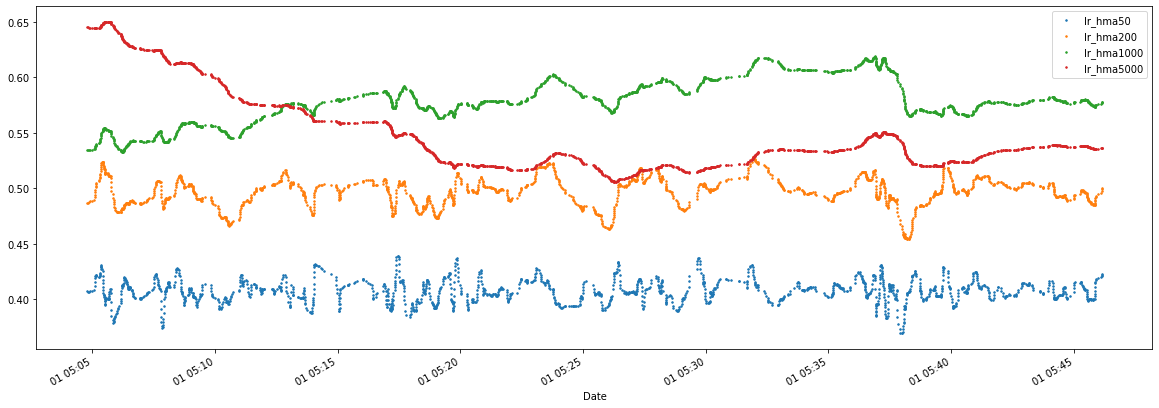

In [ ]:
rowsList = list(range(5000,6800))

sl = features.iloc[rowsList, [1,2,3,4] ]  #  4,5,6,14,  [15,16,17]  [0,3,4,5,6] [7,8,9,10]
#sl = df.iloc[rowsList, [7,8,9,10] ]  #  4,5,6,14,  [15,16,17],  [0,3,4,5,6], lr_'s [7,8,9,10]

# ploting parameters
mpl.rcParams['figure.figsize'] = (20, 7)     # set figure size 
mpl.rcParams['axes.grid'] = False

sl.plot(marker='.', linestyle='none', markersize=3)# ,linewidth=2, ) color='green', 

plt.show()

In [ ]:
#Continue here (remove normalization operation on log return columns above)
print(df.columns)
print(features.columns)
print(len(df))
print(len(features))

Index(['bid', 'ask', 'spread', 'hma50', 'hma200', 'hma1000', 'hma5000',
       'lr_hma50', 'lr_hma200', 'lr_hma1000', 'lr_hma5000', 'mom10_hma50',
       'mom10_hma200', 'mom10_hma1000', 'mom10_hma5000', 'delta_hma50_hma5000',
       'delta_hma50_hma200', 'delta_hma200_hma1000', 'delta_hma1000_hma5000',
       'delta_hma200_hma5000', 'Open', 'High', 'Low', 'Close', 'Volume'],
      dtype='object')
Index(['spread', 'lr_hma50', 'lr_hma200', 'lr_hma1000', 'lr_hma5000',
       'mom10_hma50', 'mom10_hma200', 'mom10_hma1000', 'mom10_hma5000',
       'delta_hma50_hma5000', 'delta_hma50_hma200', 'delta_hma200_hma1000',
       'delta_hma1000_hma5000', 'delta_hma200_hma5000'],
      dtype='object')
1078170
1078170


In [ ]:
#mundgedfeatures = (features[['mom10_hma50','mom10_hma200','mom10_hma1000','mom10_hma5000']]).copy().astype(float)
# rename columns to those in example code
#mundgedfeatures.columns = ['RSI', 'CMO', 'MOM', 'MFI']

#print(mundgedfeatures.columns)
'''
train_features = pd.DataFrame(
            {
                'RSI': ((talib.RSI(df['Close'], timeperiod=ROLLING).to_frame().fillna(50.0) - 50) / 100).values.flatten(),
                'CMO': ((talib.CMO(df['Close'], timeperiod=ROLLING).to_frame().fillna(0.0)) / 100).values.flatten(),
                'MOM': df['Close'].pct_change(ROLLING).to_frame().fillna(0.0).values.flatten(),
                'MFI': ((talib.MFI(df['High'], df['Low'], df['Close'], df['Volume'], timeperiod=ROLLING) - 50) / 100).fillna(0.0).values.flatten()
            }, index = df.index
        )
'''
train_features = pd.DataFrame(
            {
                'RSI': features.mom10_hma50.values.flatten(),
                'CMO': features.mom10_hma200.values.flatten(),
                'MOM': features.mom10_hma1000.values.flatten(),
                'MFI': features.mom10_hma5000.values.flatten()
            }, index = features.index
        )


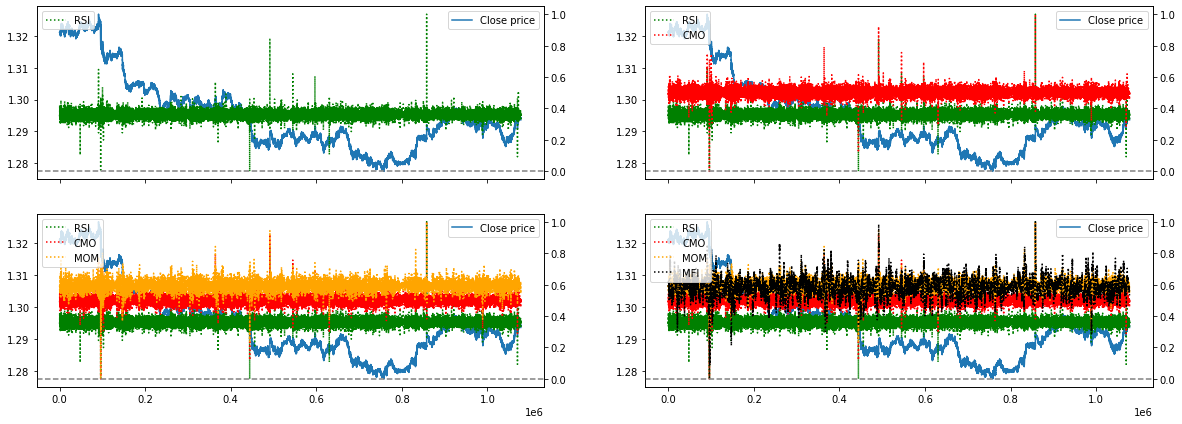

In [ ]:
'''
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (20, 7), sharex=True)

ax1.plot(df['Close'].values, label = 'Close price')
ax1_copy = ax1.twinx()
ax1_copy.plot(train_features['RSI'].values, label = 'RSI', color = 'green', ls = 'dotted')
ax1_copy.axhline(0.0, ls = '--', color = 'grey')

ax2.plot(df['Close'].values, label = 'Close price')
ax2_copy = ax2.twinx()
ax2_copy.plot(train_features['RSI'].values, label = 'RSI', color = 'green', ls = 'dotted')
ax2_copy.plot(train_features['CMO'].values, label = 'CMO', color = 'red', ls = 'dotted')
ax2_copy.axhline(0.0, ls = '--', color = 'grey')

ax3.plot(df['Close'].values, label = 'Close price')
ax3_copy = ax3.twinx()
ax3_copy.plot(train_features['RSI'].values, label = 'RSI', color = 'green', ls = 'dotted')
ax3_copy.plot(train_features['CMO'].values, label = 'CMO', color = 'red', ls = 'dotted')
ax3_copy.plot(train_features['MOM'].values, label = 'MOM', color = 'orange', ls = 'dotted')
ax3_copy.axhline(0.0, ls = '--', color = 'grey')

ax4.plot(df['Close'].values, label = 'Close price')
ax4_copy = ax4.twinx()
ax4_copy.plot(train_features['RSI'].values, label = 'RSI', color = 'green', ls = 'dotted')
ax4_copy.plot(train_features['CMO'].values, label = 'CMO', color = 'red', ls = 'dotted')
ax4_copy.plot(train_features['MOM'].values, label = 'MOM', color = 'orange', ls = 'dotted')
ax4_copy.plot(train_features['MFI'].values, label = 'MFI', color = 'black', ls = 'dotted')
ax4_copy.axhline(0.0, ls = '--', color = 'grey')

ax1.legend(loc=0)
ax1_copy.legend(loc=2)
ax2.legend(loc=0)
ax2_copy.legend(loc=2)
ax3.legend(loc=0)
ax3_copy.legend(loc=2)
ax4.legend(loc=0)
ax4_copy.legend(loc=2)
plt.show()
'''

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (20, 7), sharex=True)

ax1.plot(df['Close'].values, label = 'Close price')
ax1_copy = ax1.twinx()
ax1_copy.plot(train_features['RSI'].values, label = 'RSI', color = 'green', ls = 'dotted')
ax1_copy.axhline(0.0, ls = '--', color = 'grey')

ax2.plot(df['Close'].values, label = 'Close price')
ax2_copy = ax2.twinx()
ax2_copy.plot(train_features['RSI'].values, label = 'RSI', color = 'green', ls = 'dotted')
ax2_copy.plot(train_features['CMO'].values, label = 'CMO', color = 'red', ls = 'dotted')
ax2_copy.axhline(0.0, ls = '--', color = 'grey')

ax3.plot(df['Close'].values, label = 'Close price')
ax3_copy = ax3.twinx()
ax3_copy.plot(train_features['RSI'].values, label = 'RSI', color = 'green', ls = 'dotted')
ax3_copy.plot(train_features['CMO'].values, label = 'CMO', color = 'red', ls = 'dotted')
ax3_copy.plot(train_features['MOM'].values, label = 'MOM', color = 'orange', ls = 'dotted')
ax3_copy.axhline(0.0, ls = '--', color = 'grey')

ax4.plot(df['Close'].values, label = 'Close price')
ax4_copy = ax4.twinx()
ax4_copy.plot(train_features['RSI'].values, label = 'RSI', color = 'green', ls = 'dotted')
ax4_copy.plot(train_features['CMO'].values, label = 'CMO', color = 'red', ls = 'dotted')
ax4_copy.plot(train_features['MOM'].values, label = 'MOM', color = 'orange', ls = 'dotted')
ax4_copy.plot(train_features['MFI'].values, label = 'MFI', color = 'black', ls = 'dotted')
ax4_copy.axhline(0.0, ls = '--', color = 'grey')

ax1.legend(loc=0)
ax1_copy.legend(loc=2)
ax2.legend(loc=0)
ax2_copy.legend(loc=2)
ax3.legend(loc=0)
ax3_copy.legend(loc=2)
ax4.legend(loc=0)
ax4_copy.legend(loc=2)
plt.show()

In [ ]:
# Environment

from stable_baselines3 import A2C, PPO
from stable_baselines3.common.vec_env import DummyVecEnv



In [ ]:
'''
class StockTradingEnv(gym.Env):

    def __init__(self, df, init_account_balance, window_shape, random_start = False):
        # initialize environment
        super(StockTradingEnv, self).__init__()
        # raw dataset
        self.df = df
        # how much $ do we have?
        self.init_account_balance = init_account_balance
        self.balance = self.init_account_balance
        self.net_worth = self.init_account_balance

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.window_shape = window_shape
        self.action_space = spaces.Discrete(2)
        self.random_start = random_start

        # current step, starts with window size or random
        if not self.random_start:
            self.current_step = self.window_shape
        else:
            self.current_step = random.randint(self.window_shape, len(self.df) - self.window_shape)

        # process data initially
        self.process_data()

        # share costs
        self.in_position = False
        self.position_value = 0.0
        self.price_bought = 0.0
        self.bet_bought = 0.0

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = self.init_account_balance
        self.net_worth = self.init_account_balance  
        if not self.random_start:
            self.current_step = self.window_shape
        else:
            self.current_step = random.randint(self.window_shape, len(self.df) - self.window_shape)
        self.in_position = False
        self.position_value = 0.0
        self.price_bought = 0.0
        self.bet_bought = 0.0
        return self.get_observation()

    def process_data(self):
        self.start, self.end = self.window_shape, len(self.df)
        self.prices = self.df.iloc[self.start:self.end] 

        self.signal_features = pd.DataFrame(
            {
                'RSI': ((talib.RSI(self.df['Close'], timeperiod=ROLLING).to_frame().fillna(50.0) - 50) / 100).values.flatten(),
                'CMO': ((talib.CMO(self.df['Close'], timeperiod=ROLLING).to_frame().fillna(0.0)) / 100).values.flatten(),
                'MOM': self.df['Close'].pct_change(ROLLING).to_frame().fillna(0.0).values.flatten(),
                'MFI': ((talib.MFI(self.df['High'], self.df['Low'], self.df['Close'], self.df['Volume'], timeperiod=ROLLING) - 50) / 100).fillna(0.0).values.flatten()
            }, 
            index = self.df.index).iloc[self.start:self.end]
        
        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(
            low=-1, high=1, shape=(self.window_shape, self.signal_features.shape[-1]), dtype=np.float16
        )

    def get_observation(self):
        market_state = self.signal_features.iloc[self.current_step-self.window_shape:self.current_step]
        return market_state

    def step(self, action):
        self.take_action(action)
        self.current_step += 1

        if self.current_step > len(self.df) - self.window_shape:
            self.current_step = self.window_shape

        reward = self.net_worth

        done = False
        if (self.net_worth <= 0) or (self.current_step >= (len(self.df) - self.window_shape)):
            done = True

        obs = self.get_observation()
        return obs, reward, done, {}

    def take_action(self, action):

        # Set the current price to a random price within the time step
        current_price = random.uniform(
              self.df.iloc[self.current_step]["Open"],
              self.df.iloc[self.current_step]["Close"]
          )

        if not self.in_position:
            if action == 1: # OPEN LONG
                self.in_position = True
                self.price_bought = current_price
                self.bet_bought = self.balance
                self.balance -= self.bet_bought
                self.position_value = self.bet_bought
            else: # KEEP LOOKING
                pass
        else:
            market_return = ((current_price - self.price_bought) / self.price_bought)
            if action == 1: # HOLD LONG
                self.position_value = self.bet_bought * (1.0 + market_return)
            else: # CLOSE LONG
                self.balance += self.bet_bought * (1.0 + market_return)
                self.in_position = False
                self.price_bought = 0.0
                self.bet_bought = 0.0
                self.position_value = 0.0                

        self.net_worth = self.balance + self.position_value

    def render(self, mode='human'):
        return {
            'step': self.current_step,
            'balance': self.balance,
            'position': self.position_value,
            'net_worth': self.net_worth,
            'profit': self.net_worth - self.init_account_balance
        }
'''
class StockTradingEnv(gym.Env):

    def __init__(self, df, init_account_balance, window_shape, random_start = False):
        # initialize environment
        super(StockTradingEnv, self).__init__()
        # raw dataset
        self.df = df
        # how much $ do we have?
        self.init_account_balance = init_account_balance
        self.balance = self.init_account_balance
        self.net_worth = self.init_account_balance

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.window_shape = window_shape
        self.action_space = spaces.Discrete(2)
        self.random_start = random_start

        # current step, starts with window size or random
        if not self.random_start:
            self.current_step = self.window_shape
        else:
            self.current_step = random.randint(self.window_shape, len(self.df) - self.window_shape)

        # process data initially
        self.process_data()

        # share costs
        self.in_position = False
        self.position_value = 0.0
        self.price_bought = 0.0
        self.bet_bought = 0.0

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = self.init_account_balance
        self.net_worth = self.init_account_balance  
        if not self.random_start:
            self.current_step = self.window_shape
        else:
            self.current_step = random.randint(self.window_shape, len(self.df) - self.window_shape)
        self.in_position = False
        self.position_value = 0.0
        self.price_bought = 0.0
        self.bet_bought = 0.0
        return self.get_observation()

    def process_data(self):
        self.start, self.end = self.window_shape, len(self.df)
        self.prices = self.df.iloc[self.start:self.end] 

        self.signal_features = pd.DataFrame(
            {
                '''
                'RSI': ((talib.RSI(self.df['Close'], timeperiod=ROLLING).to_frame().fillna(50.0) - 50) / 100).values.flatten(),
                'CMO': ((talib.CMO(self.df['Close'], timeperiod=ROLLING).to_frame().fillna(0.0)) / 100).values.flatten(),
                'MOM': self.df['Close'].pct_change(ROLLING).to_frame().fillna(0.0).values.flatten(),
                'MFI': ((talib.MFI(self.df['High'], self.df['Low'], self.df['Close'], self.df['Volume'], timeperiod=ROLLING) - 50) / 100).fillna(0.0).values.flatten()
                '''
                'RSI': features.mom10_hma50.values.flatten(),
                'CMO': features.mom10_hma200.values.flatten(),
                'MOM': features.mom10_hma1000.values.flatten(),
                'MFI': features.mom10_hma5000.values.flatten()
            }, 
            index = self.df.index).iloc[self.start:self.end]
        
        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(
            low=-1, high=1, shape=(self.window_shape, self.signal_features.shape[-1]), dtype=np.float16
        )

    def get_observation(self):
        market_state = self.signal_features.iloc[self.current_step-self.window_shape:self.current_step]
        return market_state

    def step(self, action):
        self.take_action(action)
        self.current_step += 1

        if self.current_step > len(self.df) - self.window_shape:
            self.current_step = self.window_shape

        reward = self.net_worth

        done = False
        if (self.net_worth <= 0) or (self.current_step >= (len(self.df) - self.window_shape)):
            done = True

        obs = self.get_observation()
        return obs, reward, done, {}

    def take_action(self, action):

        # Set the current price to a random price within the time step
        current_price = random.uniform(
              self.df.iloc[self.current_step]["Open"],
              self.df.iloc[self.current_step]["Close"]
          )

        if not self.in_position:
            if action == 1: # OPEN LONG
                self.in_position = True
                self.price_bought = current_price
                self.bet_bought = self.balance
                self.balance -= self.bet_bought
                self.position_value = self.bet_bought
            else: # KEEP LOOKING
                pass
        else:
            market_return = ((current_price - self.price_bought) / self.price_bought)
            if action == 1: # HOLD LONG
                self.position_value = self.bet_bought * (1.0 + market_return)
            else: # CLOSE LONG
                self.balance += self.bet_bought * (1.0 + market_return)
                self.in_position = False
                self.price_bought = 0.0
                self.bet_bought = 0.0
                self.position_value = 0.0                

        self.net_worth = self.balance + self.position_value

    def render(self, mode='human'):
        return {
            'step': self.current_step,
            'balance': self.balance,
            'position': self.position_value,
            'net_worth': self.net_worth,
            'profit': self.net_worth - self.init_account_balance
        }


In [ ]:
N_TIME_STEPS = len(features) - WINDOW
LR = 0.001
RANDOM_SEED = 11111

In [ ]:
print(df.columns)

Index(['bid', 'ask', 'spread', 'hma50', 'hma200', 'hma1000', 'hma5000',
       'lr_hma50', 'lr_hma200', 'lr_hma1000', 'lr_hma5000', 'mom10_hma50',
       'mom10_hma200', 'mom10_hma1000', 'mom10_hma5000', 'delta_hma50_hma5000',
       'delta_hma50_hma200', 'delta_hma200_hma1000', 'delta_hma1000_hma5000',
       'delta_hma200_hma5000', 'Open', 'High', 'Low', 'Close', 'Volume'],
      dtype='object')


In [ ]:
# The algorithms require a vectorized environment to run
env_train = DummyVecEnv([lambda: StockTradingEnv(features, INIT_NET_WORTH, WINDOW)])
env_train_viz = DummyVecEnv([lambda: StockTradingEnv(features, INIT_NET_WORTH, WINDOW)])
model = A2C('MlpPolicy', env_train, verbose=1, learning_rate=LR, seed=RANDOM_SEED)
model.learn(total_timesteps=N_TIME_STEPS, log_interval=100)

Using cpu device


KeyError: ignored

In [ ]:
# In-sample evaluation

def evaluate_agent(env, df, model):
    obs = env.reset()
    history = {
        'balance': [],
        'action': [],
        'position': [],
        'net_worth': []
    }

    for i in range(len(df) - WINDOW):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        if done[0] == True:
            break
        state = env.render()
        history['action'].append(action)
        history['balance'].append(state['balance'])
        history['net_worth'].append(state['net_worth'])
        history['position'].append(state['position'])

    actions_over_time = np.array(history['action'])
    return history, actions_over_time

In [ ]:
history, actions_over_time = evaluate_agent(env_train_viz, df, model)

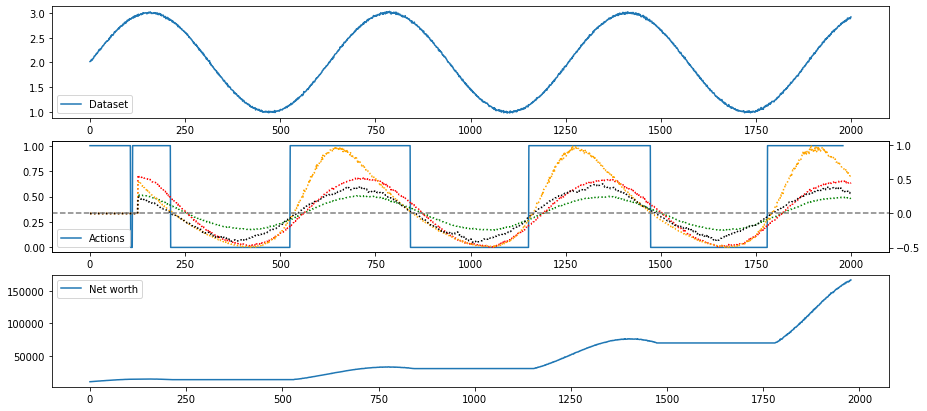

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))
ax1.plot(df['Close'].values, label = 'Dataset')

ax2.plot(actions_over_time.flatten(), label = 'Actions')
ax2_copy = ax2.twinx()
ax2_copy.plot(train_features['RSI'].values, label = 'RSI', color = 'green', ls = 'dotted')
ax2_copy.plot(train_features['CMO'].values, label = 'CMO', color = 'red', ls = 'dotted')
ax2_copy.plot(train_features['MOM'].values, label = 'MOM', color = 'orange', ls = 'dotted')
ax2_copy.plot(train_features['MFI'].values, label = 'MFI', color = 'black', ls = 'dotted')
ax2_copy.axhline(0.0, ls = '--', color = 'grey')

ax3.plot(np.array(history['net_worth']), label = 'Net worth')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()


In [ ]:
# Evaluation single holdout out-of-sample

if TICKER == 'COSINE':
    df_test = pd.DataFrame({
        'High': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.1, size = (2000, )),
        'Open': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.1, size = (2000, )),
        'Close': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.1, size = (2000, )),
        'Low': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.1, size = (2000, )),
        'Volume': np.abs(np.sin(np.arange(2000)/100.0)),
      }
      )
else:
    df_test = yf.download(TICKER, start="2011-01-01", end="2021-07-01")



In [ ]:
test_features = pd.DataFrame(
            {
                'RSI': ((talib.RSI(df_test['Close'], timeperiod=ROLLING).to_frame().fillna(50.0) - 50) / 100).values.flatten(),
                'CMO': ((talib.CMO(df_test['Close'], timeperiod=ROLLING).to_frame().fillna(0.0)) / 100).values.flatten(),
                'MOM': df_test['Close'].pct_change(ROLLING).to_frame().fillna(0.0).values.flatten(),
                'MFI': ((talib.MFI(df_test['High'], df_test['Low'], df_test['Close'], df_test['Volume'], timeperiod=ROLLING) - 50) / 100).fillna(0.0).values.flatten()
            }, index = df_test.index
        )

In [ ]:
env_test = DummyVecEnv([lambda: StockTradingEnv(df_test, INIT_NET_WORTH, WINDOW)])

In [ ]:
history_test, actions_over_time_test = evaluate_agent(env_test, df_test, model)

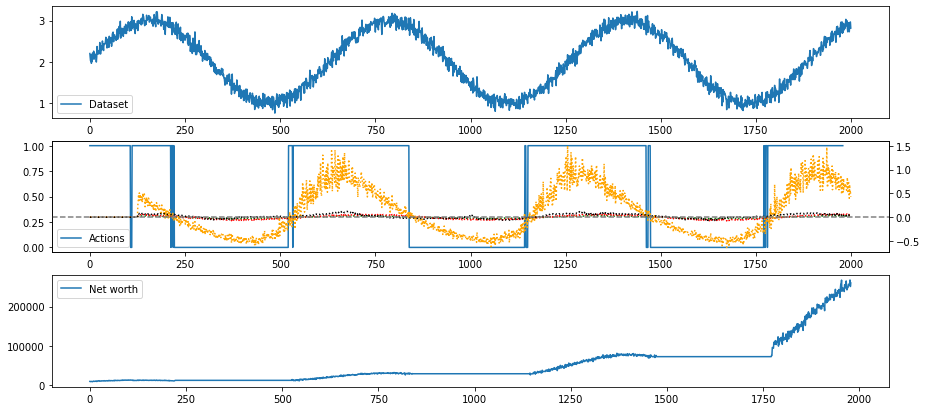

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))
ax1.plot(df_test['Close'], label = 'Dataset')
ax2.plot(actions_over_time_test.flatten(), label = 'Actions')
ax2_copy = ax2.twinx()
ax2_copy.plot(test_features['RSI'].values, label = 'RSI', color = 'green', ls = 'dotted')
ax2_copy.plot(test_features['CMO'].values, label = 'CMO', color = 'red', ls = 'dotted')
ax2_copy.plot(test_features['MOM'].values, label = 'MOM', color = 'orange', ls = 'dotted')
ax2_copy.plot(test_features['MFI'].values, label = 'MFI', color = 'black', ls = 'dotted')
ax2_copy.axhline(0.0, ls = '--', color = 'grey')
ax3.plot(np.array(history_test['net_worth']), label = 'Net worth')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()